In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.io import fits

from cycspec_simulator import (
    TemplateProfile,
    BasebandModel,
    FreqOnlyPredictor,
    ExponentialScatteringModel,
    pspec_ryan4,
    pspec_corrfirst,
    pspec_numba,
)

%matplotlib notebook

In [2]:
template_file = "B1937+21.Rcvr1_2.GUPPI.15y.x.sum.sm"
template = TemplateProfile.from_file(template_file)
template.normalize()
template.make_posdef()

Adjusting I**2 by 5.5361972783884994e-08


In [4]:
pulse_freq = 641.948222127829 # Hz
bandwidth = 1.5625e6 # Hz
predictor = FreqOnlyPredictor(pulse_freq)
model = BasebandModel(template, bandwidth=bandwidth, predictor=predictor)

In [5]:
scattering_model = ExponentialScatteringModel(scattering_time=2e-6, bandwidth=model.bandwidth, cutoff=20)
pattern = scattering_model.realize()

In [6]:
%time data = model.sample(2**19)

CPU times: user 1.12 s, sys: 37.2 ms, total: 1.15 s
Wall time: 1.17 s


In [7]:
%time data_scattered = pattern.scatter(data)

CPU times: user 28.1 ms, sys: 22 µs, total: 28.2 ms
Wall time: 28 ms


In [8]:
%time pspec1 = pspec_ryan4(data_scattered, 128, 256, predictor)

CPU times: user 5.05 s, sys: 2.2 s, total: 7.25 s
Wall time: 7.25 s


In [9]:
%time pspec2 = pspec_corrfirst(data_scattered, 128, 256, predictor)

CPU times: user 3.14 s, sys: 653 ms, total: 3.79 s
Wall time: 3.8 s


In [11]:
%time pspec3 = pspec_numba(data_scattered, 128, 256, predictor)

CPU times: user 538 ms, sys: 7.42 ms, total: 545 ms
Wall time: 538 ms


In [12]:
(
    np.allclose(pspec2.I, pspec1.I),
    np.allclose(pspec2.Q, pspec1.Q),
    np.allclose(pspec2.U, pspec1.U),
    np.allclose(pspec2.V, pspec1.V),
)

(True, True, True, True)

In [13]:
(
    np.allclose(pspec3.I, pspec1.I),
    np.allclose(pspec3.Q, pspec1.Q),
    np.allclose(pspec3.U, pspec1.U),
    np.allclose(pspec3.V, pspec1.V),
)

(False, False, False, False)

<IPython.core.display.Javascript object>


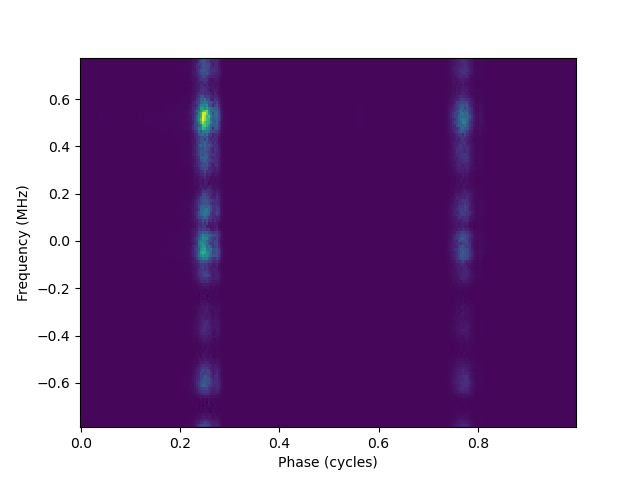

In [14]:
pspec3.plot(shift=0.25)
plt.show()